# Generating terrain using a Deep Convolutional GAN

In [1]:
from __future__ import print_function

import argparse
import os
import random

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data

import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

Set random function seeds for reproducability.

In [2]:
seed = 999

#manualSeed = random.randint(1, 10000)
random.seed(seed)
torch.manual_seed(seed)

print(seed)

999


Define data directory and the number of dataloader workers.

In [3]:
data_directory = "data/terrain"
n_workers = 2

## Settings and hyperparameters

In [5]:
batch_size = 4
image_size = 64

n_channels = 3
n_latent   = 100

n_gen_features = 64
n_dis_features = 64

n_epochs    = 5
learning_r  = 0.0002
beta1       = 0.5

n_gpus = 0

## Generator

In [4]:
class Generator(nn.Module):
    def __init__(self, n_gpus):
        super(Generator, self).__init__()
        self.n_gpus = n_gpus
        self.main = nn.Sequential(
            nn.ConvTranspose2d(n_latent, n_gen_features * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(n_gen_features * 8),
            nn.ReLU(True),

            nn.ConvTranspose2d(n_gen_features * 8, n_gen_features * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(n_gen_features * 4),
            nn.ReLU(True),

            nn.ConvTranspose2d(n_gen_features * 4, n_gen_features * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(n_gen_features * 2),
            nn.ReLU(True),

            nn.ConvTranspose2d(n_gen_features * 2, n_gen_features, 4, 2, 1, bias=False),
            nn.BatchNorm2d(n_gen_features),
            nn.ReLU(True),

            nn.ConvTranspose2d(n_gen_features, n_channels, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)


## Discriminator

In [6]:
class Discriminator(nn.Module):
    def __init__(self, n_gpus):
        super(Discriminator, self).__init__()
        self.n_gpus = n_gpus
        self.main = nn.Sequential(
            nn.Conv2d(n_channels, n_dis_features, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(n_dis_features, n_dis_features * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(n_dis_features * 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(n_dis_features * 2, n_dis_features * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(n_dis_features * 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(n_dis_features * 4, n_dis_features * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(n_dis_features * 8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(n_dis_features * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

## Loading the dataset

In [7]:
dataset_transforms = transforms.Compose([
                        transforms.Resize(image_size),
                        transforms.CenterCrop(image_size),
                        transforms.ToTensor(),
                        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                    ])

dataset = dset.ImageFolder(root=data_directory, transform=dataset_transforms)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=n_workers)

In [8]:
run_cuda = torch.cuda.is_available() and n_gpus > 0 
device   = torch.device("cuda:0" if run_cuda else "cpu")

Dataset preview

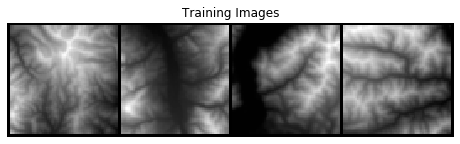

In [9]:
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

Function for weight initialization

In [10]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


## Generator and discriminator definition and initialization

In [11]:
generator = Generator(n_gpus).to(device)
discriminator = Discriminator(n_gpus).to(device)

if device.type is 'cuda' and n_gpus > 1:
    generator = nn.DataParallel(n_gpus, list(range(n_gpus)))
    discriminator = nn.DataParallel(n_gpus, list(range(n_gpus)))

generator.apply(weights_init)
discriminator.apply(weights_init)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

## Loss function and optimizer initialization

In [12]:
criterion = nn.BCELoss()

fixed_noise = torch.randn(batch_size, n_latent, 1, 1, device=device)

real_label = 1
fake_label = 0

d_optimizer = optim.Adam(discriminator.parameters(), lr=learning_r, betas=(beta1, 0.999))
g_optimizer = optim.Adam(generator.parameters(), lr=learning_r, betas=(beta1, 0.999))

## Training

In [14]:
# Start training
for epoch in range(n_epochs):
    for i, data in enumerate(dataloader, 0):
        # Train discriminator
        discriminator.zero_grad()

        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)

        # Train discriminator with real batch
        label = torch.full((b_size,), real_label, device=device)

        output = discriminator(real_cpu).view(-1)

        d_error_r = criterion(output, label)
        d_error_r.backward(retain_graph=True)

        # Train discriminator with fake batch
        noise = torch.randn(b_size, n_latent, 1, 1, device=device)

        fake = generator(noise)
        label.fill_(fake_label)

        output = discriminator(fake)

        d_error_f = criterion(output, label)
        d_error_f.backward(retain_graph=True)

        # Step discriminator
        d_error = d_error_r + d_error_f
        d_optimizer.step()

        # Train generator
        generator.zero_grad()
        label.fill_(real_label)

        output = discriminator(fake).view(-1)

        g_error = criterion(output, label)
        g_error.backward(retain_graph=True)

        g_optimizer.step()

        if i % 50 is 0:
            print('[%d/%d][%d/%d]\t d_loss: %.4f\t g_loss: %.4f' %
                (epoch, n_epochs, i, len(dataloader), d_error.item(), g_error.item()))

[0/5][0/225]	 d_loss: 0.0241	 g_loss: 5.2814
[0/5][50/225]	 d_loss: 0.4397	 g_loss: 11.7482
[0/5][100/225]	 d_loss: 1.8341	 g_loss: 33.1132


KeyboardInterrupt: 